In [265]:
import chdb
import calendar
from datetime import datetime, timedelta
from chdb.session import Session
import chdb.dataframe as cdf
from pathlib import Path
import time
from zoneinfo import ZoneInfo
import pandas as pd
import ta
import random

random.seed(10765)

pd.options.mode.copy_on_write = False
df = None

def loadOptimisedSampleData(parquetFile):
    #Load optimised dataframe from parquet file
    start = time.time()
    dfFile = parquetFile #'./oanda_data_pandas.parquet'
    df = pd.read_parquet(path=dfFile)
    end = time.time()
    print("Loaded Optimised Sample Data:", end - start)
    return df


def week_of_month(tgtdate):
#     tgtdate = tgtdate.to_datetime()

    days_this_month = calendar.mdays[tgtdate.month]
    for i in range(1, days_this_month):
        d = datetime(tgtdate.year, tgtdate.month, i, tzinfo=ZoneInfo('EST'))
        if d.day - d.weekday() > 0:
            startdate = d
            break
    # now we canuse the modulo 7 appraoch
    return (tgtdate - startdate).days //7 + 1



In [266]:
# Add Fields for:
# Month, Week, Day of Year, Week, Day of Month, Day of Week, Hour of Day Minute of Hour, Second of Minute for Candle and for High and Low
# % of Candle Time that High Occurs and Low Occurs
# H-L Range
# O-C Range
# ATR
# Outcome = Bullish/Bearish for Candle


In [346]:
def loadIntervalDataframe(instrument, tf):
    # Load Data from Parquet:
#     instrument = 'EUR_USD'
#     tf = 'W1'

    datafile = f"../data/oanda_{instrument}_{tf}.parquet"
    df = loadOptimisedSampleData(datafile)
    # df = df.set_index(['timestamp'])
    
    if tf in ['W1', 'D1']:
        df.index = pd.to_datetime(df.index, utc=True)
    else:
        df.index = df.index.astype(pd.DatetimeTZDtype(tz=ZoneInfo('EST')))

    # Data Clean Up - need to push back into Parquet generation:
    # For some reason The Last Week in Oct starts on a Sunday instead of a Monday
    # Select all Weeks which are starting on a Sunday and add on day to the index....

    oddrows = df['tf'] = 'W1' and df.index.dayofweek >4 #| (df.tf == 'D1' & df.index.dayofweek >4)
        # df.loc[oddrows].index = df.loc[oddrows].index + timedelta(days=1)

    skewed = df.loc[oddrows].index
    [df.rename(index={x: x + timedelta(days=1)},inplace=True) for x in skewed]
    
    oddrows = df['tf'] = 'D1' and df.index.dayofweek >4 
        # df.loc[oddrows].index = df.loc[oddrows].index + timedelta(days=1)
    
    skewed = df.loc[oddrows].index
    print(skewed)
    df = df.drop(skewed)
        # oddrowsck = df['tf'] = 'W1' and df.index.dayofweek >5
        # df.loc[oddrows].head(100)
    return df

In [297]:
def weekHighProportionRow(row):
    grain = timedelta(hours=120)
    interval = pd.to_datetime(row.name, utc=True)
    interval = datetime(interval.year, interval.month, interval.day, 17,tzinfo=ZoneInfo('EST')) - timedelta(days=1)
    p = intervalProportion(grain, interval, row.high_timestamp)
    return p

def weekLowProportionRow(row):
    grain = timedelta(hours=120)
    interval = pd.to_datetime(row.name, utc=True)
    interval = datetime(interval.year, interval.month, interval.day, 17,tzinfo=ZoneInfo('EST')) - timedelta(days=1)
    p = intervalProportion(grain, interval, row.low_timestamp)
    return p

def dayHighProportionRow(row):
    grain = timedelta(hours=24)
    interval = pd.to_datetime(row.name, utc=True)
    interval = datetime(interval.year, interval.month, interval.day, 17,tzinfo=ZoneInfo('EST')) - timedelta(days=1)
    p = intervalProportion(grain, interval, row.high_timestamp)
    return p

def dayLowProportionRow(row):
    grain = timedelta(hours=24)
    interval = pd.to_datetime(row.name, utc=True)
    interval = datetime(interval.year, interval.month, interval.day, 17,tzinfo=ZoneInfo('EST')) - timedelta(days=1)
    p = intervalProportion(grain, interval, row.low_timestamp)
    return p

# Below Daily Intevals
def intervalHighProportionRow(row, minutes): 
    grain = timedelta(minutes=minutes)
#     interval = row.name.astype(pd.DatetimeTZDtype(tz=ZoneInfo('EST'))) #pd.to_datetime(row.name) #, utc=True)
    interval = row.name
    interval = datetime(interval.year, interval.month, interval.day, interval.hour, interval.minute, interval.second ,tzinfo=ZoneInfo('EST')) - timedelta(days=1)
    p = intervalProportion(grain, interval, row.high_timestamp)
    return p

def intervalLowProportionRow(row, minutes):
    grain = timedelta(minutes=minutes)
#     interval = pd.to_datetime(row.name) #, utc=True)
#     interval = row.name.astype(pd.DatetimeTZDtype(tz=ZoneInfo('EST')))
    interval = row.name
    interval = datetime(interval.year, interval.month, interval.day, interval.hour, interval.minute, interval.second ,tzinfo=ZoneInfo('EST')) - timedelta(days=1)
    p = intervalProportion(grain, interval, row.low_timestamp)
    return p

def intervalProportion(grain, interval, high_low_timestamp):
    high_low_datetime = pd.to_datetime(high_low_timestamp)
    start = interval
    segment_passed = high_low_datetime - start
    proportion = segment_passed / grain
#     print(f'interval: {interval}, high_low_datetime: {high_low_datetime}, segment_passed: {segment_passed}')
    return proportion

In [280]:
interval = datetime(2017,1,2,17, tzinfo=ZoneInfo('EST')) - timedelta(days=1)
high = '2017-01-01 17:00:05-05:00'
weekHighProportion(interval, high)

1.1574074074074073e-05

In [281]:
# Main Feature Engineering
def featureEng(df, tf_minutes):
    #Interval / Index
    df['year'] = df.index.year
    df['quarter_of_year'] = df.index.quarter
    df['month_of_year'] = df.index.month
    df['week_of_year'] = df.index.isocalendar().week
    df['week_of_month'] = df.apply(lambda row: week_of_month(row.name), axis=1)
    df['day_of_year'] = df.index.dayofyear
    df['day_of_month'] = df.index.day
    df['day_of_week'] = df.index.dayofweek
    df['hour_of_day'] = df.index.hour
    df['minute_of_hour'] = df.index.minute
    df['minute_of_day'] = (df.index.hour * 60) + df.index.minute
    df['second_of_minute'] = df.index.second
    df.index = df.index.date

    # High Time Stamp
    high_ts = pd.to_datetime(df.high_timestamp)
    df['high_year'] = high_ts.dt.year
    df['high_quarter_of_year'] = high_ts.dt.quarter
    df['high_month_of_year'] = high_ts.dt.month
    df['high_week_of_year'] = high_ts.dt.isocalendar().week
    df['high_week_of_month'] = high_ts.apply(week_of_month)
    df['high_day_of_year'] = high_ts.dt.dayofyear
    df['high_day_of_month'] = high_ts.dt.day
    df['high_day_of_week'] = high_ts.dt.dayofweek 
    df['high_day_of_week_sun_0'] = high_ts.apply(lambda row: (row.dayofweek+ 1)%7) #Make Sunday=0 for day of week
    df['high_day_of_week_trading'] = high_ts.apply(lambda row: (row + timedelta(hours=7)).dayofweek) #Shift so that Day aligns with Trading Day
    df['high_hour_of_day'] = high_ts.dt.hour
    # df['high_hour_of_week'] =  high_ts.apply(lambda row: row.hour + ((row.dayofweek*24)))
    # df['high_hour_of_week_trading_sun_0'] =  high_ts.apply(lambda row: row.hour + ((((row + timedelta(hours=7)).dayofweek+1)%7)*24))
    # df['high_hour_of_week_sun_0'] =  high_ts.apply(lambda row: row.hour + (((row.dayofweek+ 1)%7)*24))
    df['high_hour_of_week_trading'] =  high_ts.apply(lambda row: row.hour + ((row + timedelta(hours=7)).dayofweek*24)) # 17:00 Sun = Hour 1 -> 16:00 Fri = 120
    df['high_minute_of_hour'] = high_ts.dt.minute
    df['high_minute_of_day'] = (high_ts.dt.hour * 60) + high_ts.dt.minute
    df['high_second_of_minute'] = high_ts.dt.second


    # Low Time Stamp
    low_ts = pd.to_datetime(df.low_timestamp)
    df['low_quarter_of_year'] = low_ts.dt.quarter
    df['low_month_of_year'] = low_ts.dt.month
    df['low_week_of_year'] = low_ts.dt.isocalendar().week
    df['low_week_of_month'] = low_ts.apply(week_of_month)
    df['low_day_of_year'] = low_ts.dt.dayofyear
    df['low_day_of_month'] = low_ts.dt.day
    df['low_day_of_week'] = low_ts.dt.dayofweek
    df['low_day_of_week_sun_0'] = low_ts.apply(lambda row: (row.dayofweek+ 1)%7)
    df['low_day_of_week_trading'] = low_ts.apply(lambda row: (row + timedelta(hours=7)).dayofweek)
    df['low_hour_of_day'] = low_ts.dt.hour
    # df['low_hour_of_week'] =  low_ts.apply(lambda row: row.hour + ((row + timedelta(hours=7)).dayofweek*24))
    # df['low_hour_of_week_sun_0'] =  low_ts.apply(lambda row: row.hour + (((row.dayofweek+ 1)%7)*24))
    df['low_hour_of_week_trading'] =  low_ts.apply(lambda row: row.hour + ((row + timedelta(hours=7)).dayofweek*24))
    df['low_minute_of_hour'] = low_ts.dt.minute
    df['low_minute_of_day'] = (low_ts.dt.hour * 60) + low_ts.dt.minute
    df['low_second_of_minute'] = low_ts.dt.second
   
    

    atr_window = 50
    df['interval_range'] = df['high'] - df['low']
    df['interval_return'] = df['close'] - df['open']
    df['ATR'] = ta.volatility.average_true_range(high=df.high,low=df.low, close=df.close, window=atr_window)
    df['bullish'] = df.close >= df.open

    if tf_minutes == 10080: #'W1'
        df['high_proportion_of_week'] =df.apply(weekHighProportionRow, axis=1)
        df['low_proportion_of_week'] =df.apply(weekLowProportionRow, axis=1)
    elif tf_minutes==1440: #'D1'
        df['high_proportion_of_day'] =df.apply(dayHighProportionRow, axis=1)
        df['low_proportion_of_day'] =df.apply(dayLowProportionRow, axis=1)
    else:
        df['high_proportion_of_interval'] =df.apply(lambda row: intervalHighProportionRow(row, tf_minutes), axis=1)
        df['high_proportion_of_interval'] =df.apply(lambda row: intervalLowProportionRow(row, tf_minutes), axis=1)

    # display = df[['open','high','low', 'close','first_sample', 'last_sample', 'samples', 'month_of_year', 'week_of_year', 'week_of_month', 'day_of_year']]
    # display.head(20)

#     colnames_low = ['low_quarter_of_year', 'low_month_of_year', 'low_week_of_year', 'low_week_of_month', 'low_day_of_year', 'low_day_of_month', 'low_day_of_week', 'low_day_of_week_sun_0', 'low_day_of_week_trading', 'low_hour_of_day', 'low_minute_of_hour', 'low_minute_of_day', 'low_second_of_minute']
#     colnames_high = ['high_quarter_of_year', 'high_month_of_year', 'high_week_of_year', 'high_week_of_month', 'high_day_of_year', 'high_day_of_month', 'high_day_of_week', 'high_day_of_week_sun_0', 'high_day_of_week_trading', 'high_hour_of_day', 'high_minute_of_hour', 'high_minute_of_day', 'high_second_of_minute']

#     display = df[colnames_low]
#     display.describe()
#     # display.head(20)
    return df

In [282]:
datafile = f"../data/oanda_{instrument}_{tf}.parquet"
dft = loadOptimisedSampleData(datafile)
start_time = pd.to_datetime('2017-10-22')
end_time = pd.to_datetime('2017-11-29')

dft.index  = pd.to_datetime(dft.index)

# dft.index = df.index.astype(pd.DatetimeTZDtype(tz=ZoneInfo('EST')))

display = dft.query('index > @start_time and index < @end_time')
display.head(100)

Loaded Optimised Sample Data: 0.007298946380615234


,instrument,tf,open,high,low,close,high_timestamp,low_timestamp,first_sample,last_sample,samples
2017-10-23,EUR_USD,D1,1.17651,1.17776,1.17248,1.17496,2017-10-23 02:04:40-05:00,2017-10-23 14:13:10-05:00,2017-10-22 17:00:00-05:00,2017-10-23 16:59:45-05:00,12619
2017-10-24,EUR_USD,D1,1.17480,1.17933,1.17426,1.17610,2017-10-24 15:02:50-05:00,2017-10-24 03:23:20-05:00,2017-10-23 17:01:45-05:00,2017-10-24 16:59:45-05:00,12262
2017-10-25,EUR_USD,D1,1.17610,1.18180,1.17532,1.18127,2017-10-25 13:08:35-05:00,2017-10-24 20:38:55-05:00,2017-10-24 17:02:00-05:00,2017-10-25 16:59:45-05:00,13361
2017-10-26,EUR_USD,D1,1.18126,1.18370,1.16402,1.16520,2017-10-26 01:24:10-05:00,2017-10-26 15:48:15-05:00,2017-10-25 17:02:00-05:00,2017-10-26 16:59:45-05:00,13004
2017-10-27,EUR_USD,D1,1.16528,1.16574,1.15739,1.16082,2017-10-26 17:15:45-05:00,2017-10-27 11:35:55-05:00,2017-10-26 17:02:00-05:00,2017-10-27 16:59:55-05:00,13503
2017-10-30,EUR_USD,D1,1.16108,1.16582,1.15938,1.16517,2017-10-30 15:58:45-05:00,2017-10-29 18:43:00-05:00,2017-10-29 17:00:00-05:00,2017-10-30 16:59:45-05:00,12211
2017-10-31,EUR_USD,D1,1.16506,1.16615,1.16250,1.16456,2017-10-31 11:33:45-05:00,2017-10-31 01:00:35-05:00,2017-10-30 17:01:35-05:00,2017-10-31 16:59:45-05:00,12084
2017-11-01,EUR_USD,D1,1.16457,1.16571,1.16062,1.16194,2017-11-01 04:02:25-05:00,2017-11-01 09:50:50-05:00,2017-10-31 17:02:00-05:00,2017-11-01 16:59:45-05:00,12684
2017-11-02,EUR_USD,D1,1.16194,1.16875,1.16134,1.16586,2017-11-02 10:13:40-05:00,2017-11-01 18:21:25-05:00,2017-11-01 17:02:00-05:00,2017-11-02 16:59:45-05:00,12905
2017-11-03,EUR_USD,D1,1.16568,1.16927,1.15990,1.16085,2017-11-03 08:30:00-05:00,2017-11-03 14:02:15-05:00,2017-11-02 17:01:30-05:00,2017-11-03 16:59:55-05:00,11810


In [283]:
# Visualise
# Distribution of High % of Candle by Outcome
# Distribution of Low % of Candle by Outcome
# Distribution of High of Week by Day of Week By Outcome of Weekly Candle
# Distribution of Low of Week by Day of Week By Outcome of Weekly Candle
# Distribution of High of Week by Hour of Week By Outcome of Weekly Candle
# Distribution of Low of Week by Hour of Week By Outcome of Weekly Candle
# Distribution of High of Day by Hour of Day By Outcome of Daily Candle (+by Day of Week?)
# Distribution of Low of Day by Hour of Day By Outcome of Daily Candle (+by Day of Week?)
# H-L Range Precentile by Week of Year, Week of Month, Day of Week, Day of Year, Hour of Day, Minute of Day, Minute of Hour
# O-C Range Precentile by Week of Year, Week of Month, Day of Week, Day of Year, Hour of Day, Minute of Day, Minute of Hour


In [284]:
import numpy as np
import pandas as pd
import random
import ta
import seaborn as sns
import matplotlib.pyplot as plt

In [285]:
weekdays_std = [0,1,2,3,4,5,6]
weekdays_sun = [(x + 1)%7 for x in weekdays_std]
print(f'Weekdays_sun (Sunday=0): {weekdays_sun}')

sunday_est = datetime(2024,2,4,17, tzinfo=ZoneInfo('EST'))
print(f'sun_est: {sunday_est}. Weekday: {sunday_est.weekday()}')

sunday_est_skew = datetime(2024,2,4,17, tzinfo=ZoneInfo('EST')) + timedelta(hours=7)
print(f'sunday_est_skew: {sunday_est_skew}. Weekday: {sunday_est_skew.weekday()}')

Weekdays_sun (Sunday=0): [1, 2, 3, 4, 5, 6, 0]
sun_est: 2024-02-04 17:00:00-05:00. Weekday: 6
sunday_est_skew: 2024-02-05 00:00:00-05:00. Weekday: 0


In [286]:
# Common Functions for Viz:
def add_lables(g):
    for ax in g.axes.ravel():
        # add annotations
        for c in ax.containers:

            # custom label calculates percent and add an empty string so 0 value bars dont have a number
            labels = ['{:0.1%}'.format(w/100) if (w := v.get_height()) > 0 else '' for v in c]

            ax.bar_label(c, labels=labels, label_type='edge', fontsize=8, rotation=90, padding=2)

        ax.margins(y=0.2)

In [347]:
instrument = 'EUR_USD'

## Weekly:
tf = 'W1'
tf_minutes = 10080 #week
# Load Data:
df_weekly = loadIntervalDataframe(instrument, tf)
# Create Features:
df_weekly = featureEng(df_weekly, tf_minutes)

## Daily:
tf = 'D1'
tf_minutes = 1440 #daily
# Load Data:
df_daily = loadIntervalDataframe(instrument, tf)
# Create Features:
df_daily = featureEng(df_daily, tf_minutes)

## Hourly:
# tf = 'H1'
# tf_minutes = 60 #H1
# Load Data:
df_hourly = loadIntervalDataframe(instrument, tf)
# Create Features:
df_hourly = featureEng(df_hourly, tf_minutes)

## M15:
# tf = 'M15'
# tf_minutes = 15 #H1
# Load Data:
df_m15 = loadIntervalDataframe(instrument, tf)
# Create Features:
df_m15 = featureEng(df_m15, tf_minutes)

Loaded Optimised Sample Data: 0.007178306579589844
DatetimeIndex([], dtype='datetime64[ns, UTC]', freq=None)
Loaded Optimised Sample Data: 0.006622314453125
DatetimeIndex(['2019-10-13 00:00:00+00:00'], dtype='datetime64[ns, UTC]', freq=None)
Loaded Optimised Sample Data: 0.0059278011322021484
DatetimeIndex(['2019-10-13 00:00:00+00:00'], dtype='datetime64[ns, UTC]', freq=None)
Loaded Optimised Sample Data: 0.006206989288330078
DatetimeIndex(['2019-10-13 00:00:00+00:00'], dtype='datetime64[ns, UTC]', freq=None)


In [348]:


outliers = df_weekly.query('low_proportion_of_week>1 or high_proportion_of_week>1 or day_of_week >4')
display = outliers[['high_proportion_of_week', 'high_timestamp', 'low_proportion_of_week', 'low_timestamp', 'samples', 'first_sample', 'last_sample']]
display.head(100)

,high_proportion_of_week,high_timestamp,low_proportion_of_week,low_timestamp,samples,first_sample,last_sample


In [349]:
outliers = df_daily.query('low_proportion_of_day>1 or high_proportion_of_day>1 or day_of_week >4')
display = outliers[['high_proportion_of_day', 'high_timestamp', 'low_proportion_of_day', 'low_timestamp', 'samples', 'first_sample', 'last_sample']]
display.head(100)

,high_proportion_of_day,high_timestamp,low_proportion_of_day,low_timestamp,samples,first_sample,last_sample


In [350]:
# Sanity Check 
start_time = pd.to_datetime('2023-11-22')
end_time = pd.to_datetime('2023-11-24')

df_daily.index  = pd.to_datetime(df_daily.index)

# dft.index = df.index.astype(pd.DatetimeTZDtype(tz=ZoneInfo('EST')))
cols = ['high', 'low', 'high_timestamp', 'high_hour_of_day', 'low_timestamp', 'low_hour_of_day']
display = df_daily.query('high_hour_of_day==5 and index > @start_time and index < @end_time')
display[cols].head(100)

datafile = f"../data/oanda_{instrument}_{tf}.parquet"
dft = loadOptimisedSampleData(datafile)
dft.index  = pd.to_datetime(dft.index)
cols = ['high', 'low', 'high_timestamp', 'low_timestamp']

display = dft.query('index > @start_time and index < @end_time')
display[cols].head(100)

# dft['high_proportion_of_day'] = dft.apply(dayHighProportionRow, axis=1)
# dft['low_proportion_of_day'] = dft.apply(dayLowProportionRow, axis=1)
# cols = ['high', 'low', 'high_timestamp', 'low_timestamp', 'high_proportion_of_day', 'low_proportion_of_day']
display[cols].head(100)

Loaded Optimised Sample Data: 0.0073146820068359375


,high,low,high_timestamp,low_timestamp
2023-11-23,1.09309,1.08825,2023-11-23 03:30:10-05:00,2023-11-22 18:00:00-05:00


### High / Low of Week by Day and Hour

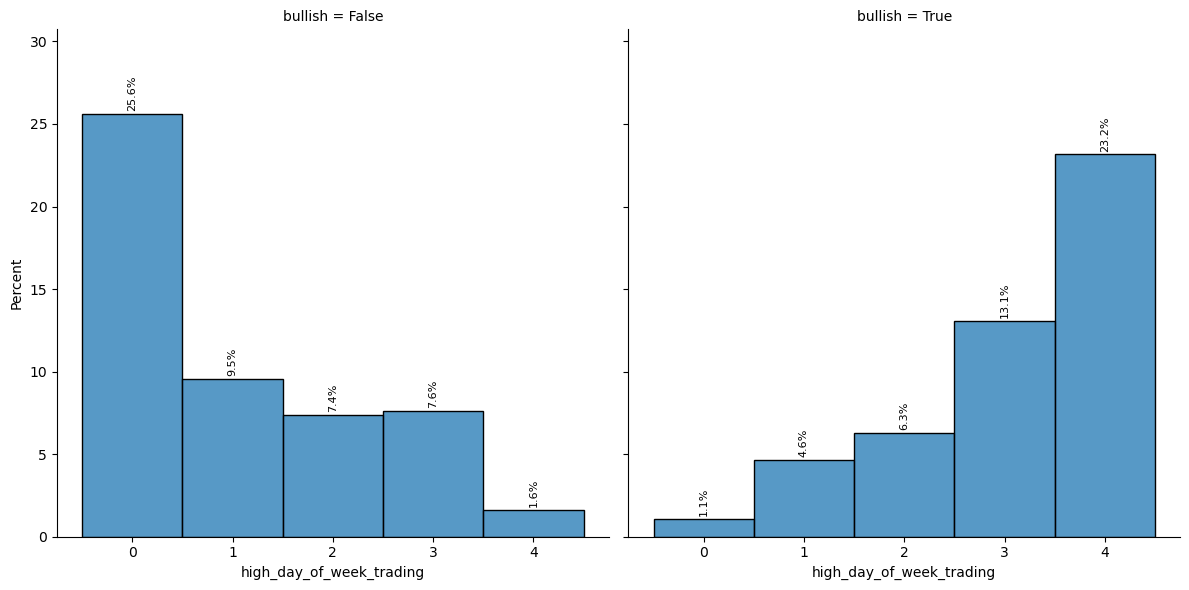

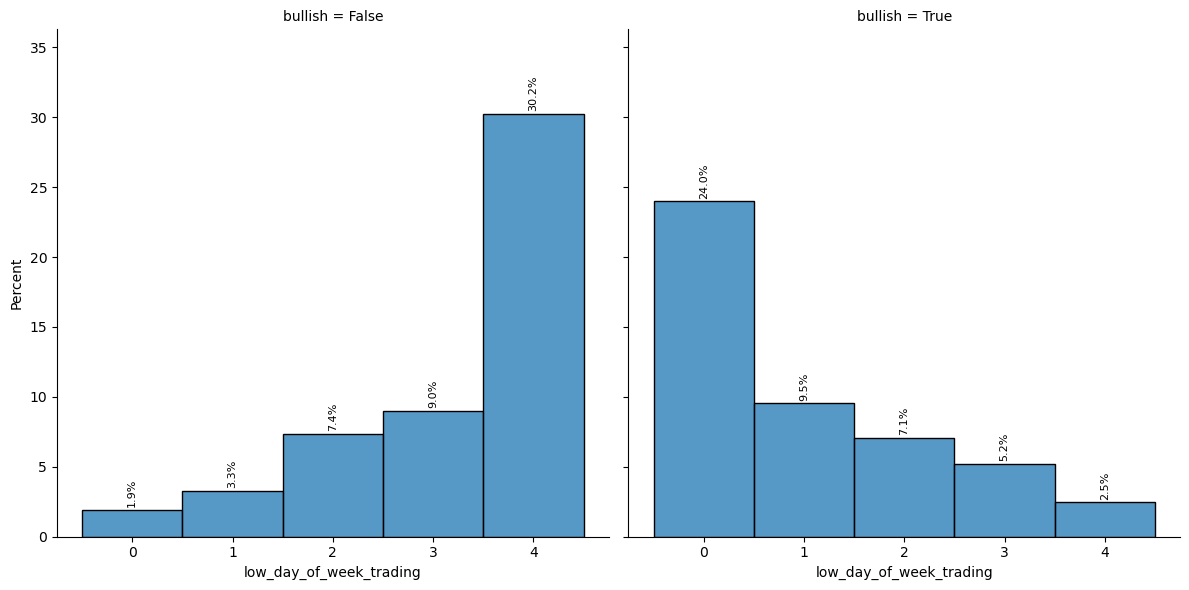

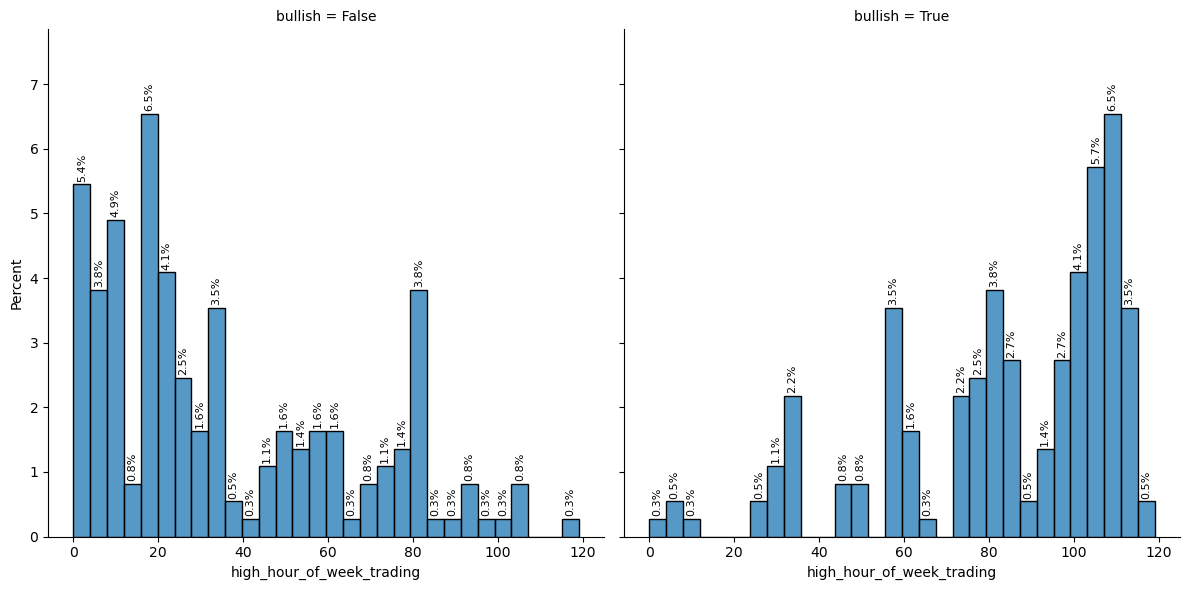

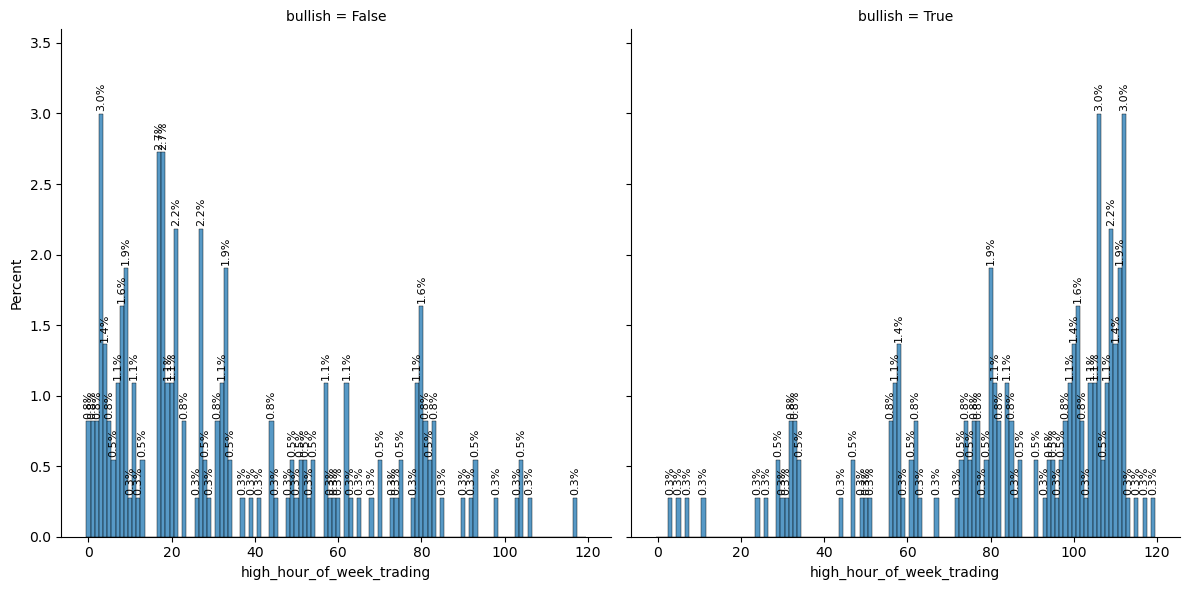

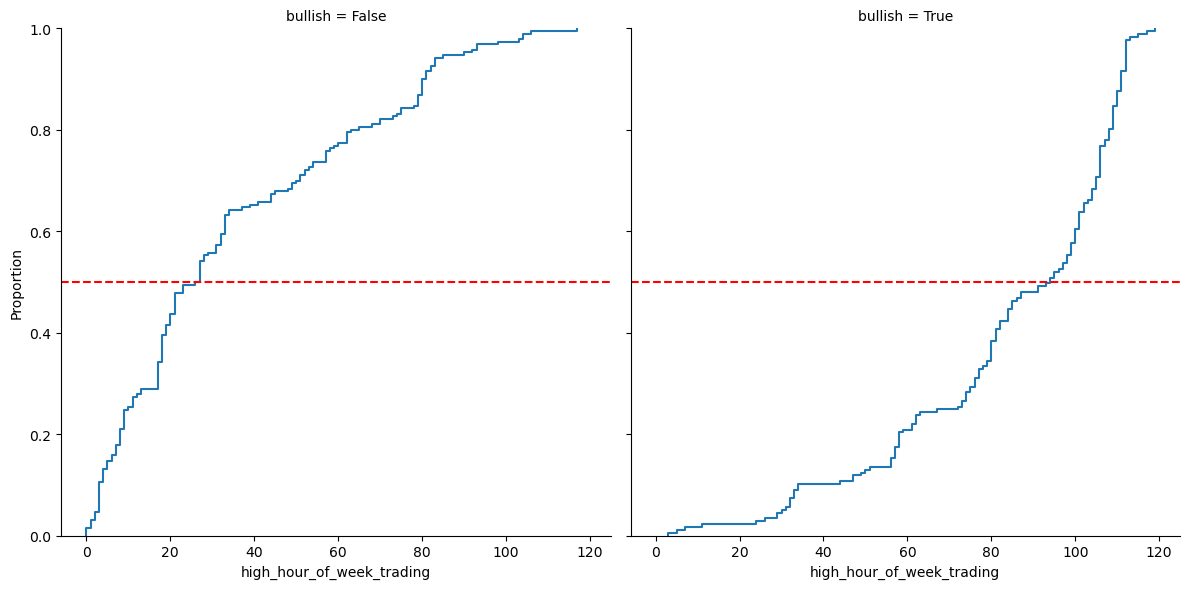

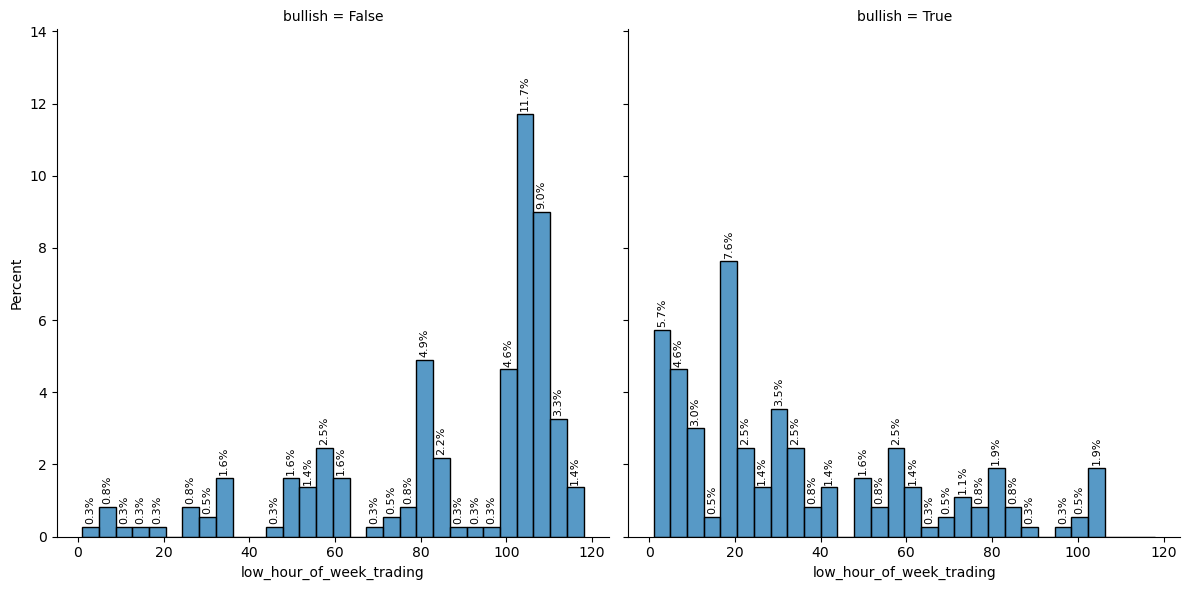

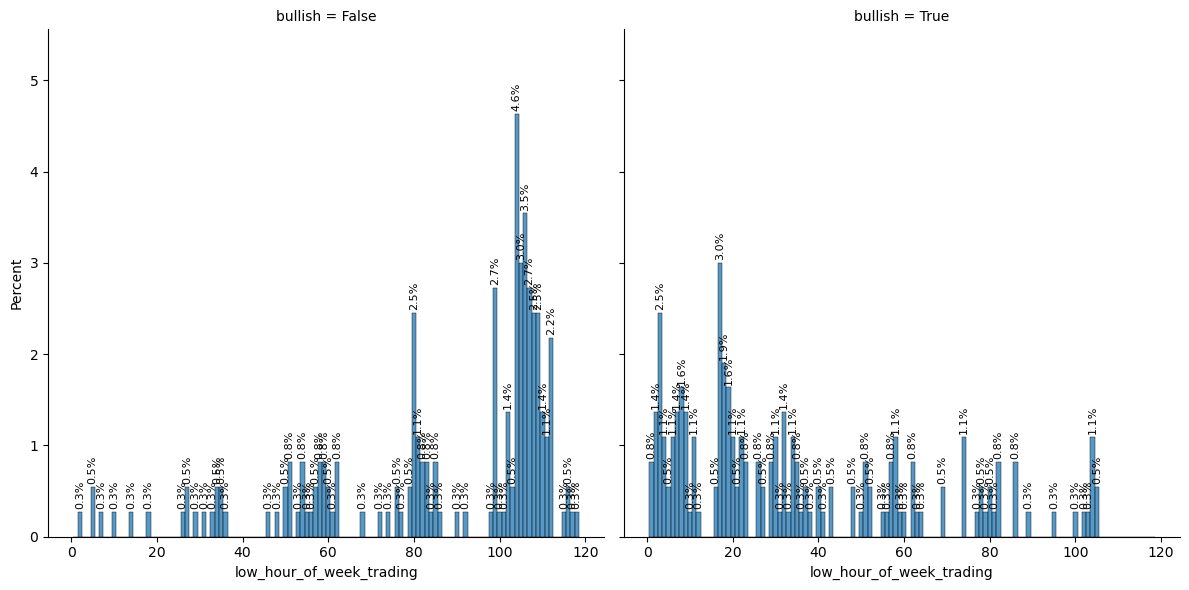

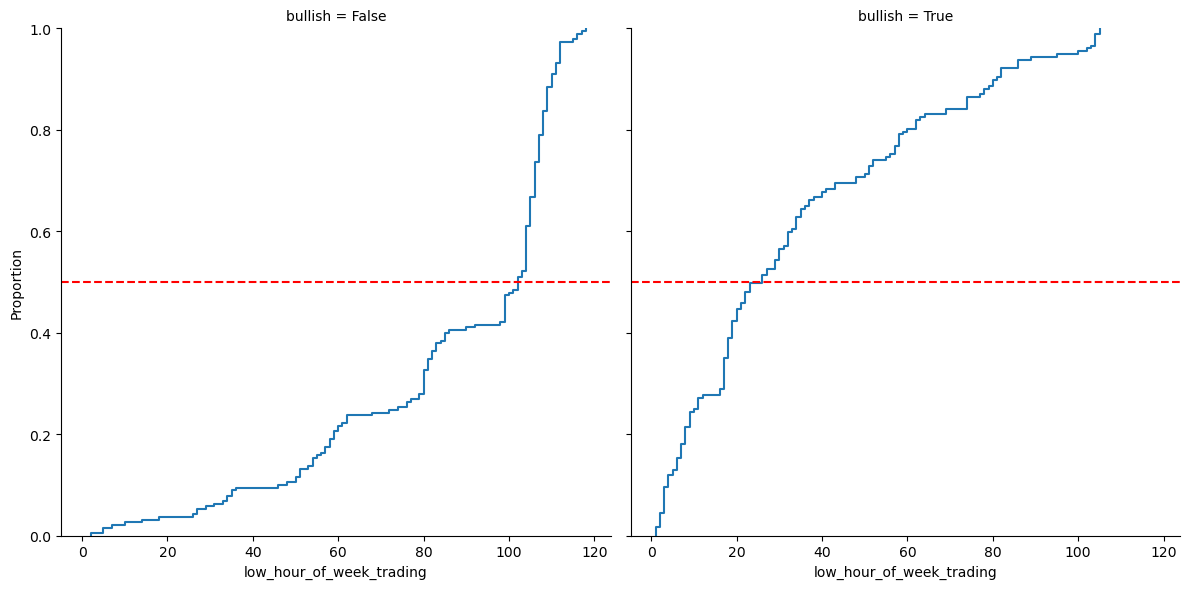

In [351]:
df_vis = df_weekly
upbars = df_vis.bullish

g = sns.displot(kind='hist', x=df_vis.high_day_of_week_trading, col=upbars, height=6, stat='percent', discrete=True)
add_lables(g)

g = sns.displot(kind='hist', x=df_vis.low_day_of_week_trading, col=upbars, height=6, stat='percent', discrete=True)
add_lables(g)

g = sns.displot(kind='hist', x=df_vis.high_hour_of_week_trading, col=upbars, height=6, stat='percent', bins=30)
add_lables(g)

g = sns.displot(kind='hist', x=df_vis.high_hour_of_week_trading, col=upbars, height=6, stat='percent', discrete=True)
add_lables(g)

g = sns.displot(kind='ecdf', x=df_vis.high_hour_of_week_trading, col=upbars, height=6, stat='proportion')
g.map(plt.axhline, y=0.5, ls='--', c='red')

g = sns.displot(kind='hist', x=df_vis.low_hour_of_week_trading, col=upbars, height=6, stat='percent', bins=30)
add_lables(g)

g = sns.displot(kind='hist', x=df_vis.low_hour_of_week_trading, col=upbars, height=6, stat='percent', discrete=True)
add_lables(g)

g = sns.displot(kind='ecdf', x=df_vis.low_hour_of_week_trading, col=upbars, height=6, stat='proportion')
g.map(plt.axhline, y=0.5, ls='--', c='red')

# g = sns.displot(kind='hist', x=df_vis.low_hour_of_week, col=upbars, height=6, stat='percent', discrete=True)
# g = sns.displot(kind='hist', x=df_vis.low_hour_of_week_sun_0, col=upbars, height=6, stat='percent', discrete=True)

# g = sns.displot(kind='hist', x=df_vis.high_day_of_week_sun_0, col=upbars, height=6, stat='percent', discrete=True)
# g = sns.displot(kind='hist', x=df_vis.low_day_of_week_sun_0, col=upbars, height=6, stat='percent', discrete=True)
# g = sns.displot(kind='ecdf', x=df_vis.high_day_of_week_sun_0, col=upbars, height=6, stat='proportion')
# g = sns.displot(kind='ecdf', x=df_vis.low_day_of_week_sun_0, col=upbars, height=6, stat='proportion')

# g = sns.FacetGrid(df_vis, row='high_year',  col=upbars)
# g.map_dataframe(sns.histplot, x="high_day_of_week")

# sns.displot(data=df_vis, x='high_day_of_week')        

### High / Low of the Week by Proportion of Weekly Interval:

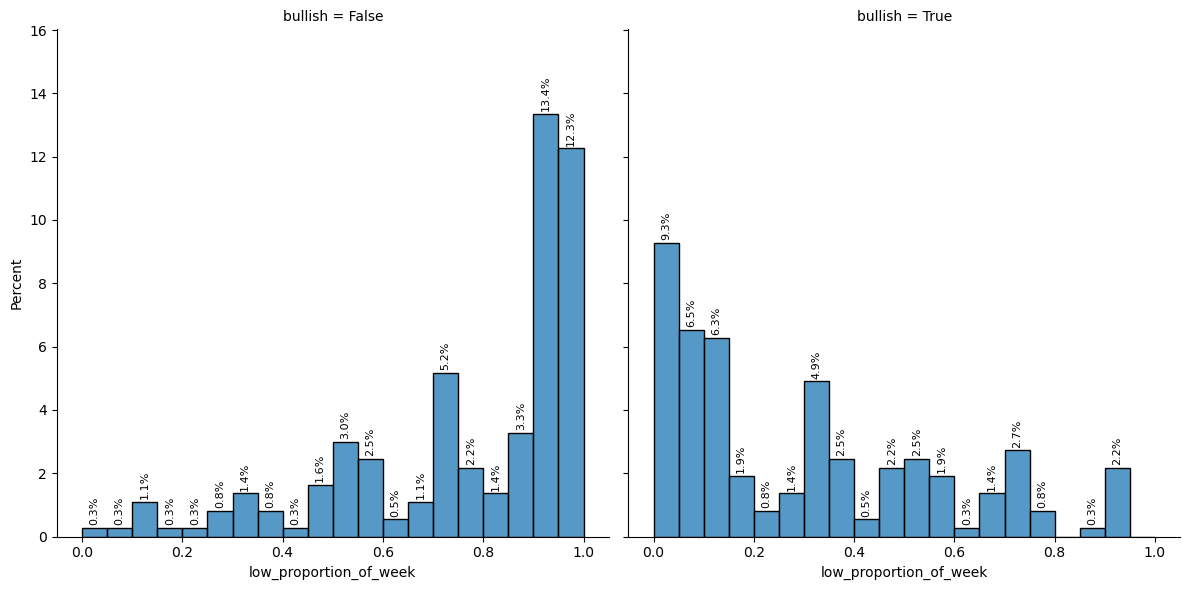

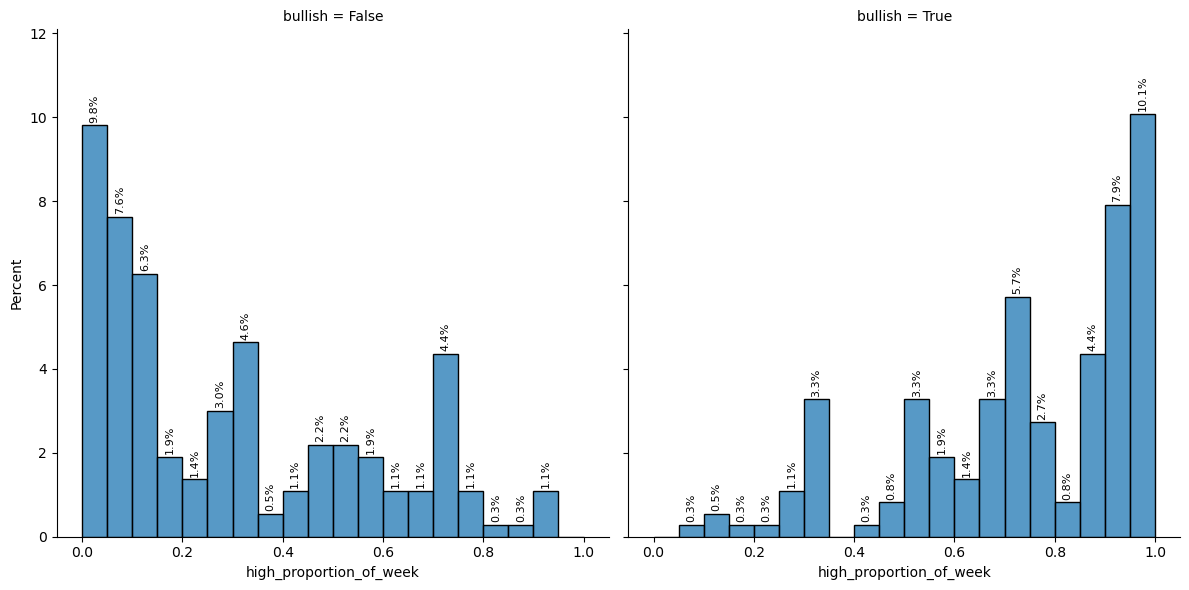

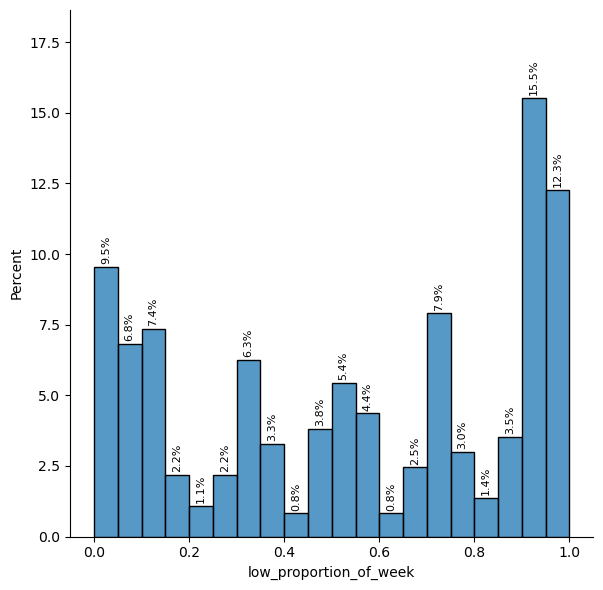

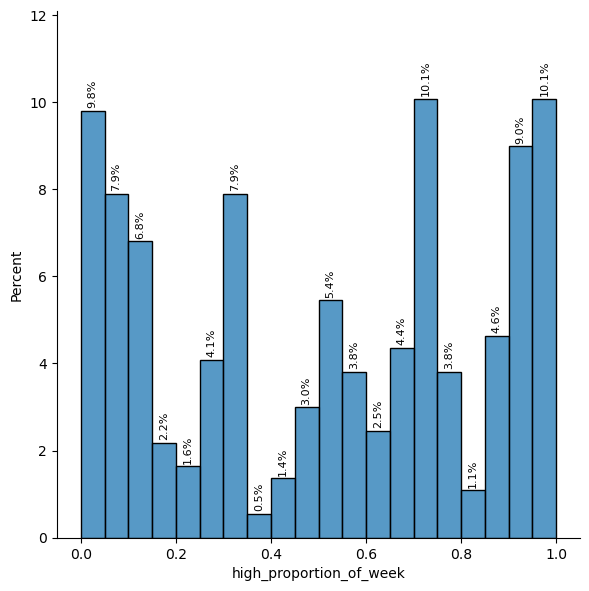

In [352]:
df_vis = df_weekly
upbars = df_vis.bullish

g = sns.displot(kind='hist', x=df_vis.low_proportion_of_week, col=upbars, height=6, stat='percent', bins=20)
add_lables(g)

g = sns.displot(kind='hist', x=df_vis.high_proportion_of_week, col=upbars, height=6, stat='percent', bins=20)
add_lables(g)

g = sns.displot(kind='hist', x=df_vis.low_proportion_of_week, height=6, stat='percent', bins=20)
add_lables(g)

g = sns.displot(kind='hist', x=df_vis.high_proportion_of_week, height=6, stat='percent', bins=20)
add_lables(g)

### High / Low of Day by Hour and Min

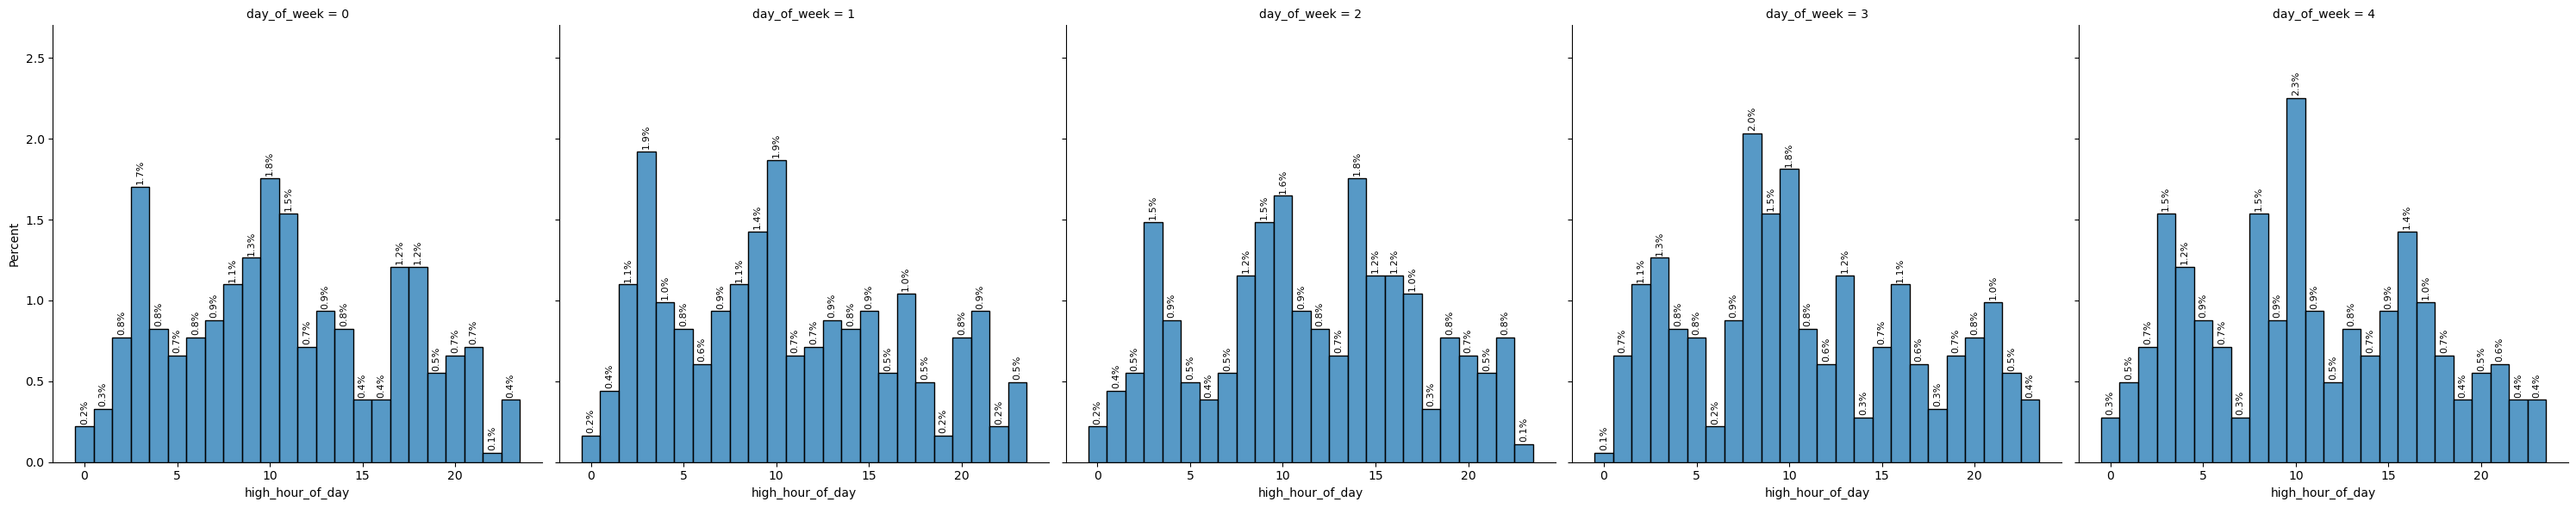

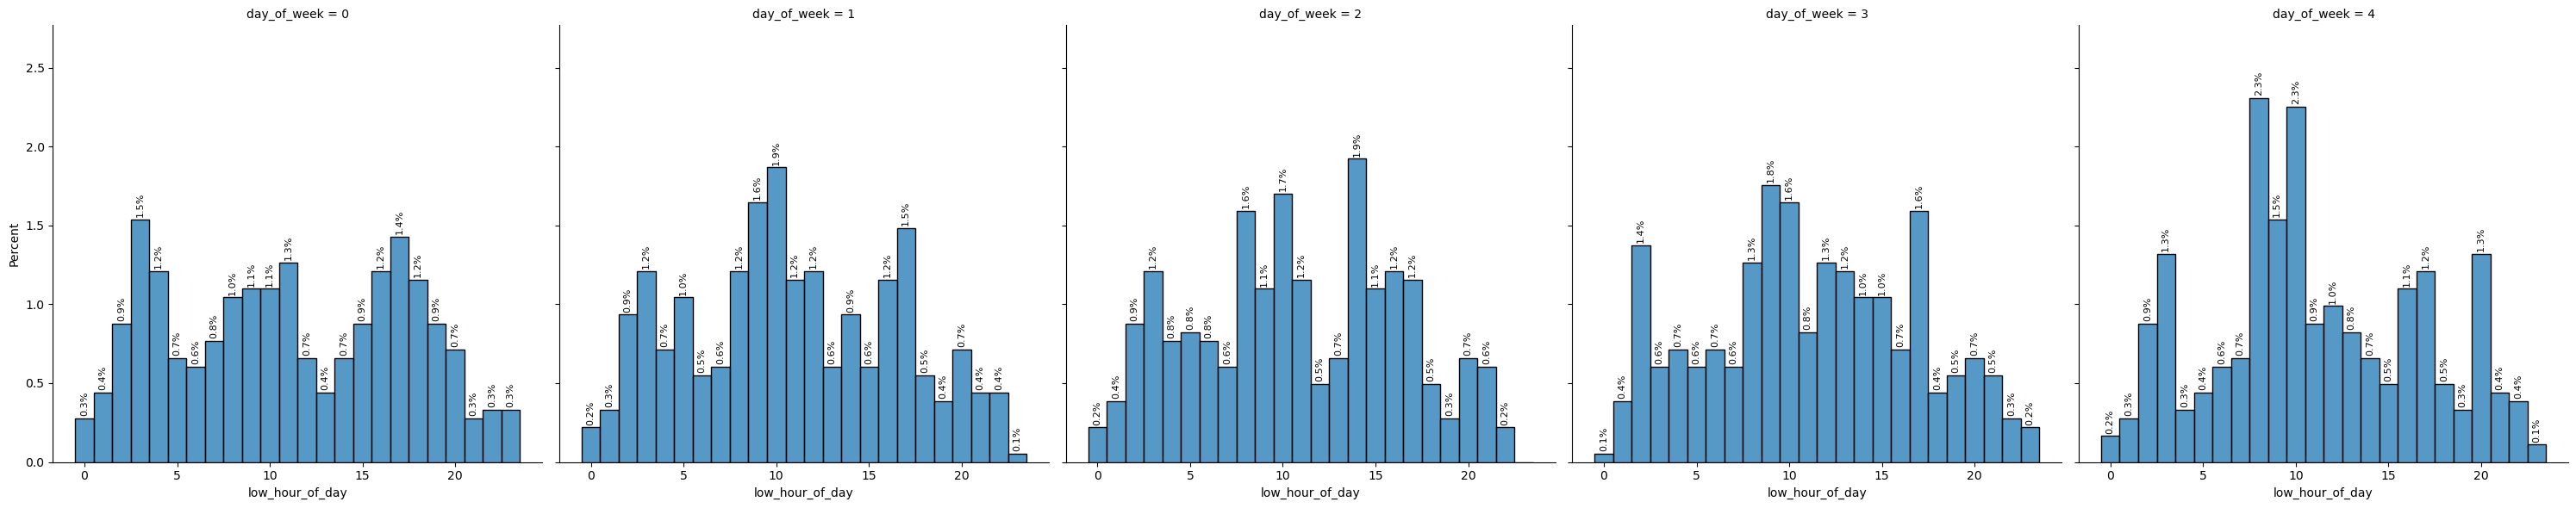

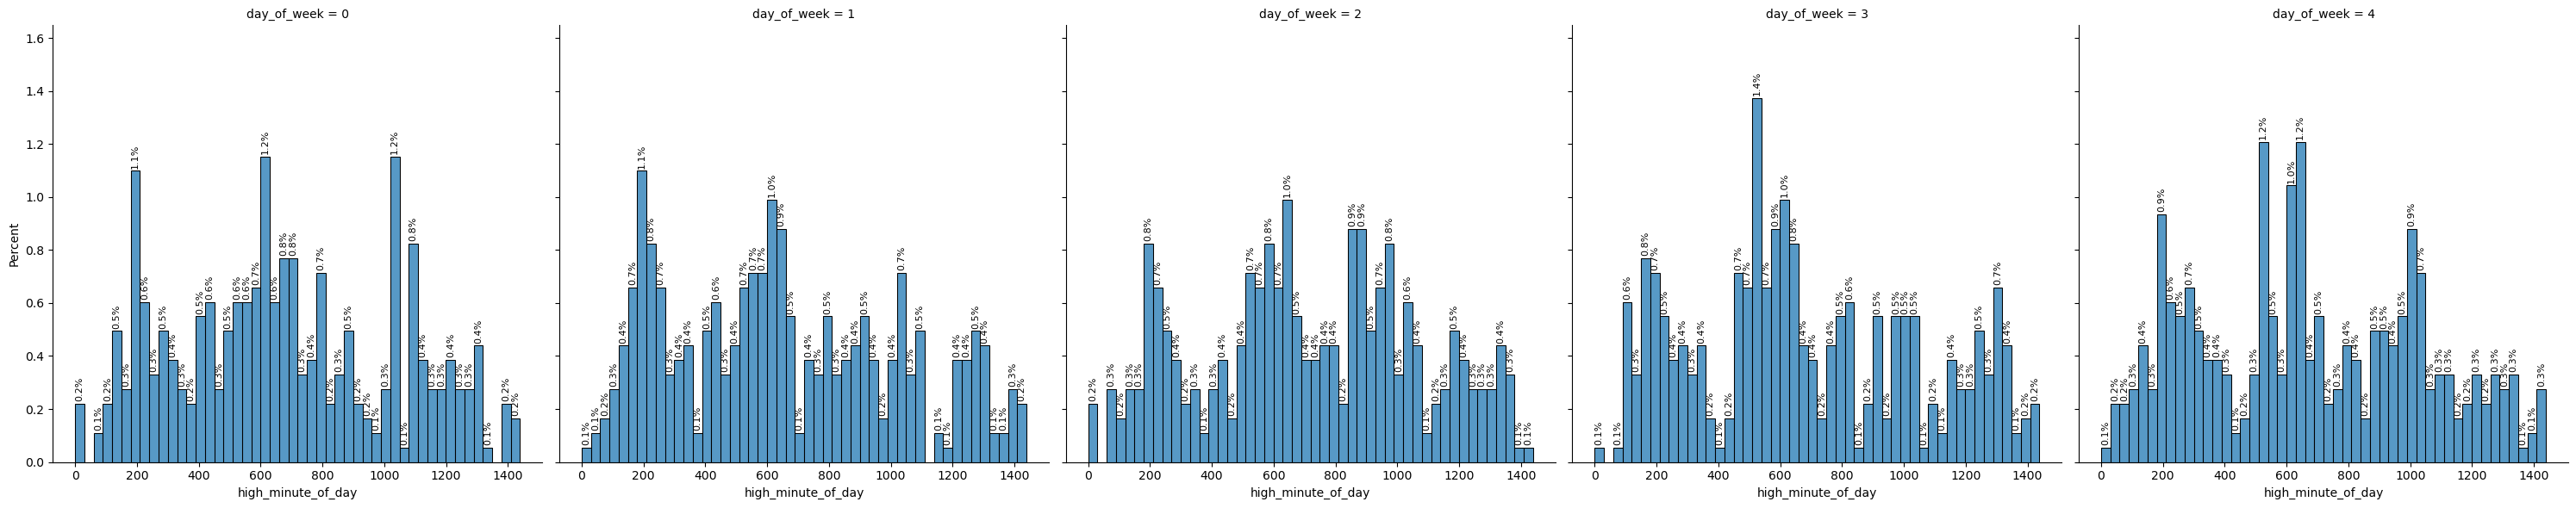

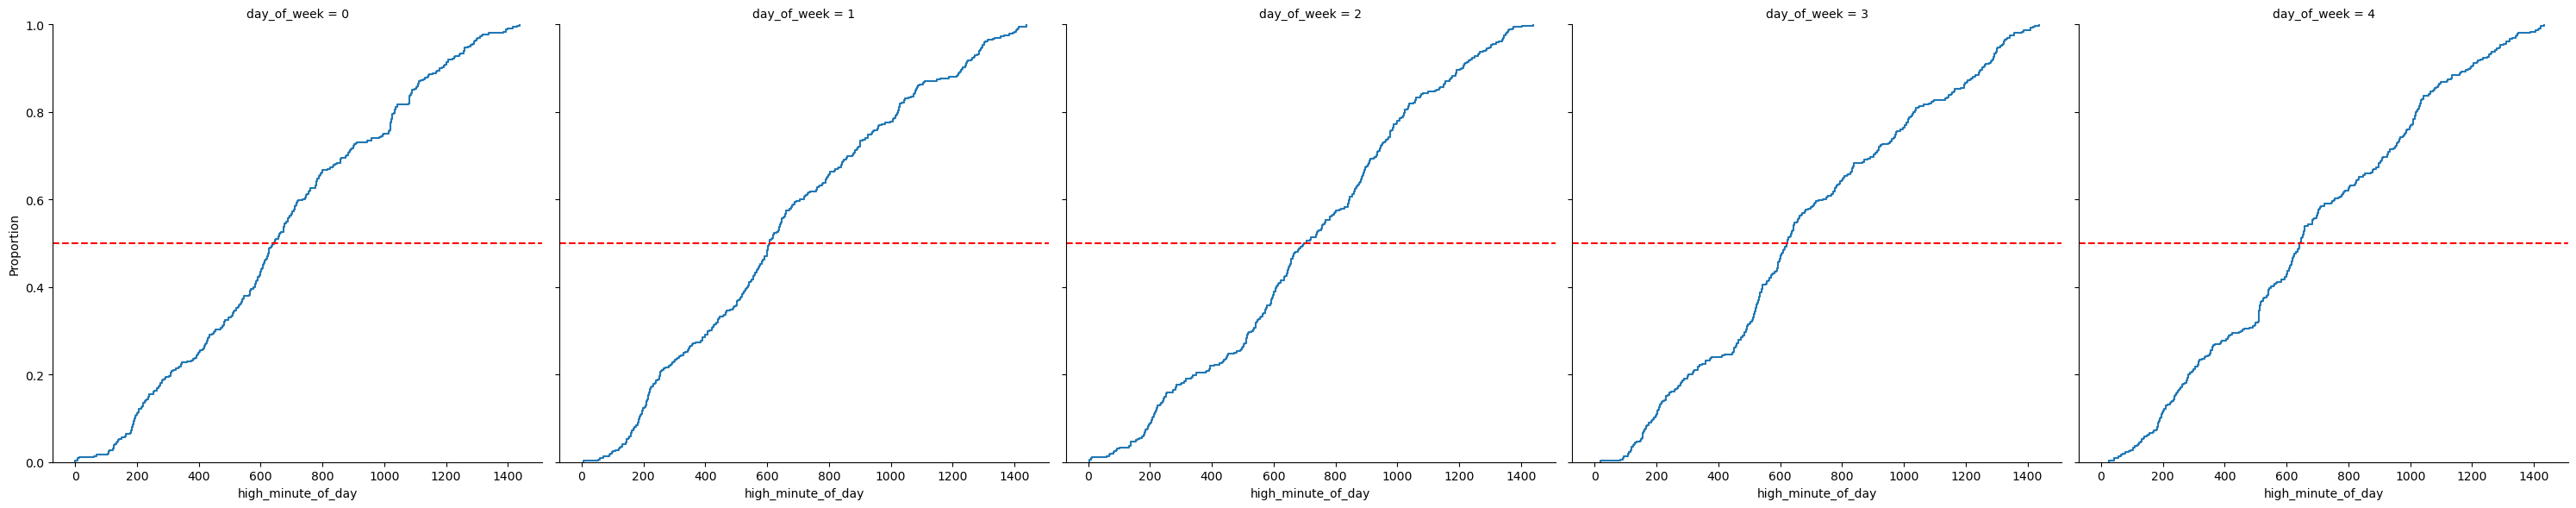

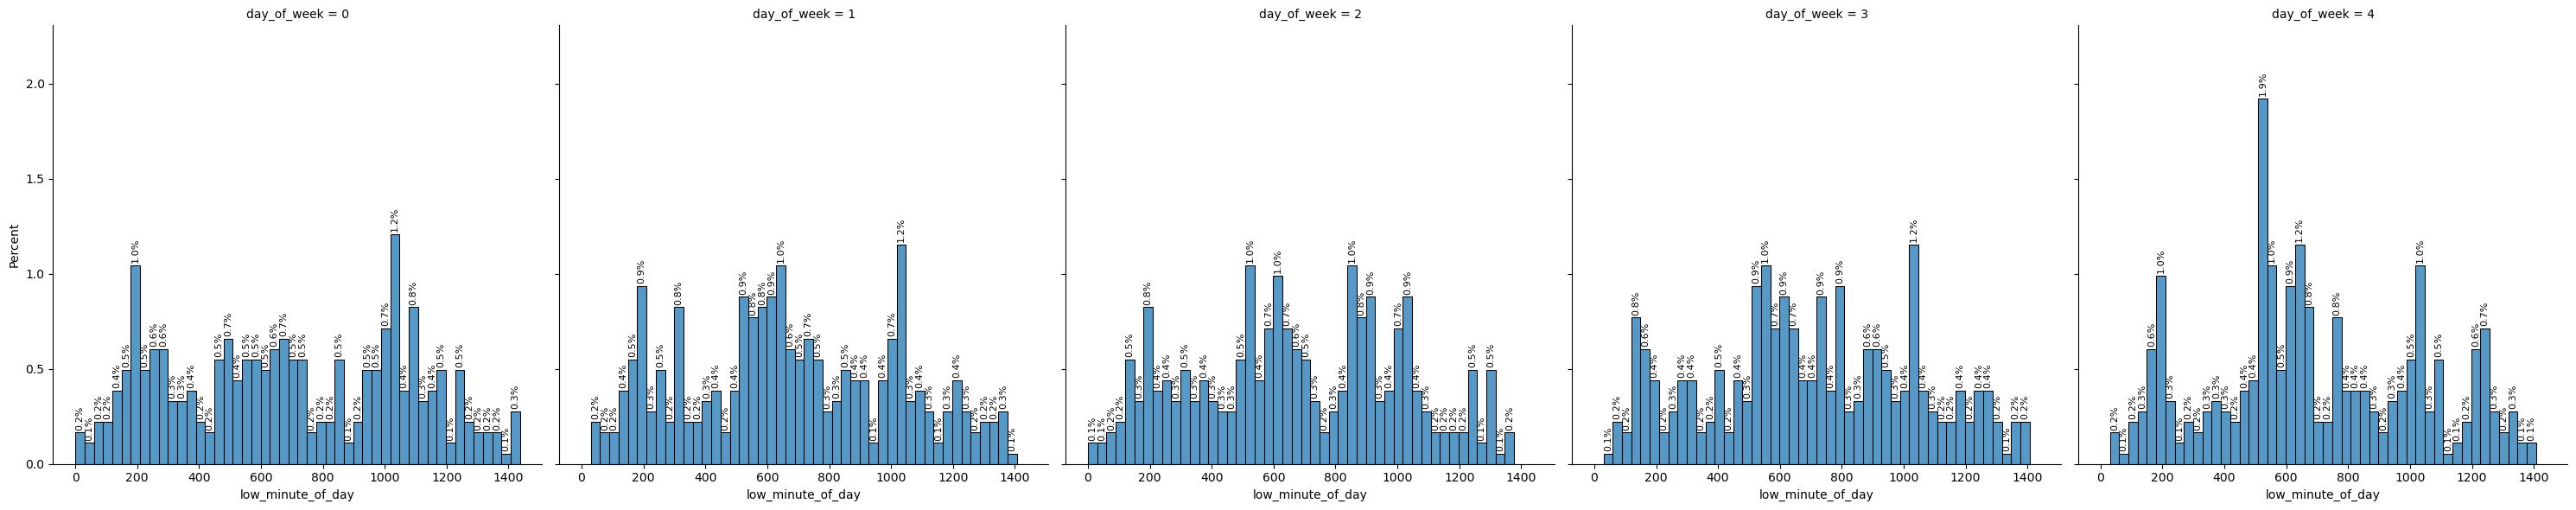

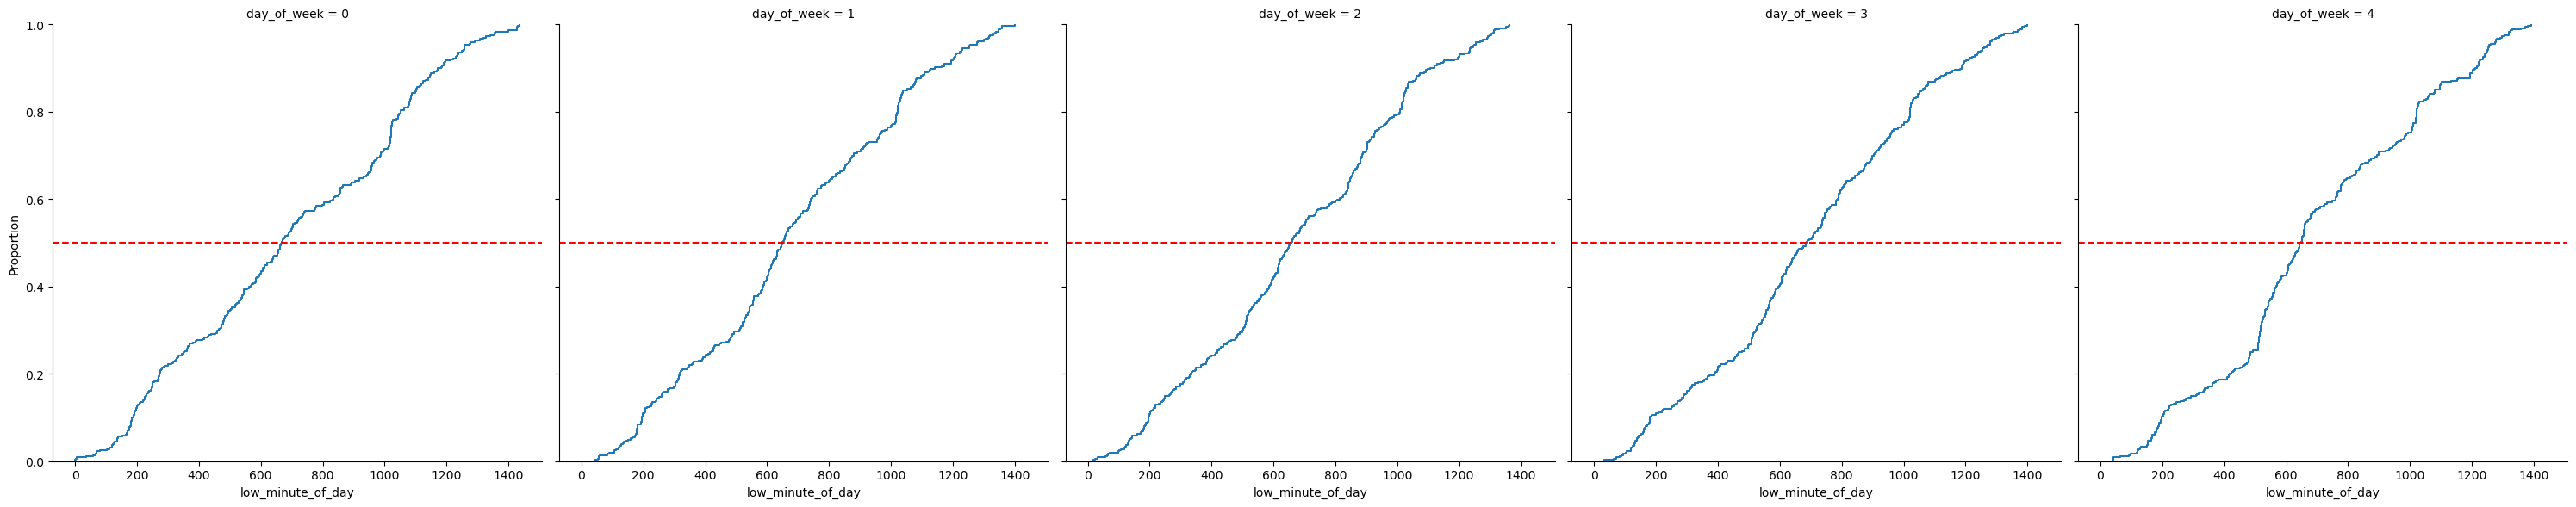

In [353]:
# Look at this split out by day
df_vis = df_daily
upbars = df_vis.day_of_week

g = sns.displot(kind='hist', x=df_vis.high_hour_of_day, col=upbars, height=6, stat='percent', discrete=True)
add_lables(g)

g = sns.displot(kind='hist', x=df_vis.low_hour_of_day, col=upbars, height=6, stat='percent', discrete=True)
add_lables(g)

g = sns.displot(kind='hist', x=df_vis.high_minute_of_day, col=upbars, height=6, stat='percent', bins=48)
add_lables(g)

g = sns.displot(kind='ecdf', x=df_vis.high_minute_of_day, col=upbars, height=6, stat='proportion')
g.map(plt.axhline, y=0.5, ls='--', c='red')

g = sns.displot(kind='hist', x=df_vis.low_minute_of_day, col=upbars, height=6, stat='percent', bins=48)
add_lables(g)

g = sns.displot(kind='ecdf', x=df_vis.low_minute_of_day, col=upbars, height=6, stat='proportion')
g.map(plt.axhline, y=0.5, ls='--', c='red')


### High / Low of the Day by Proportion of Day:

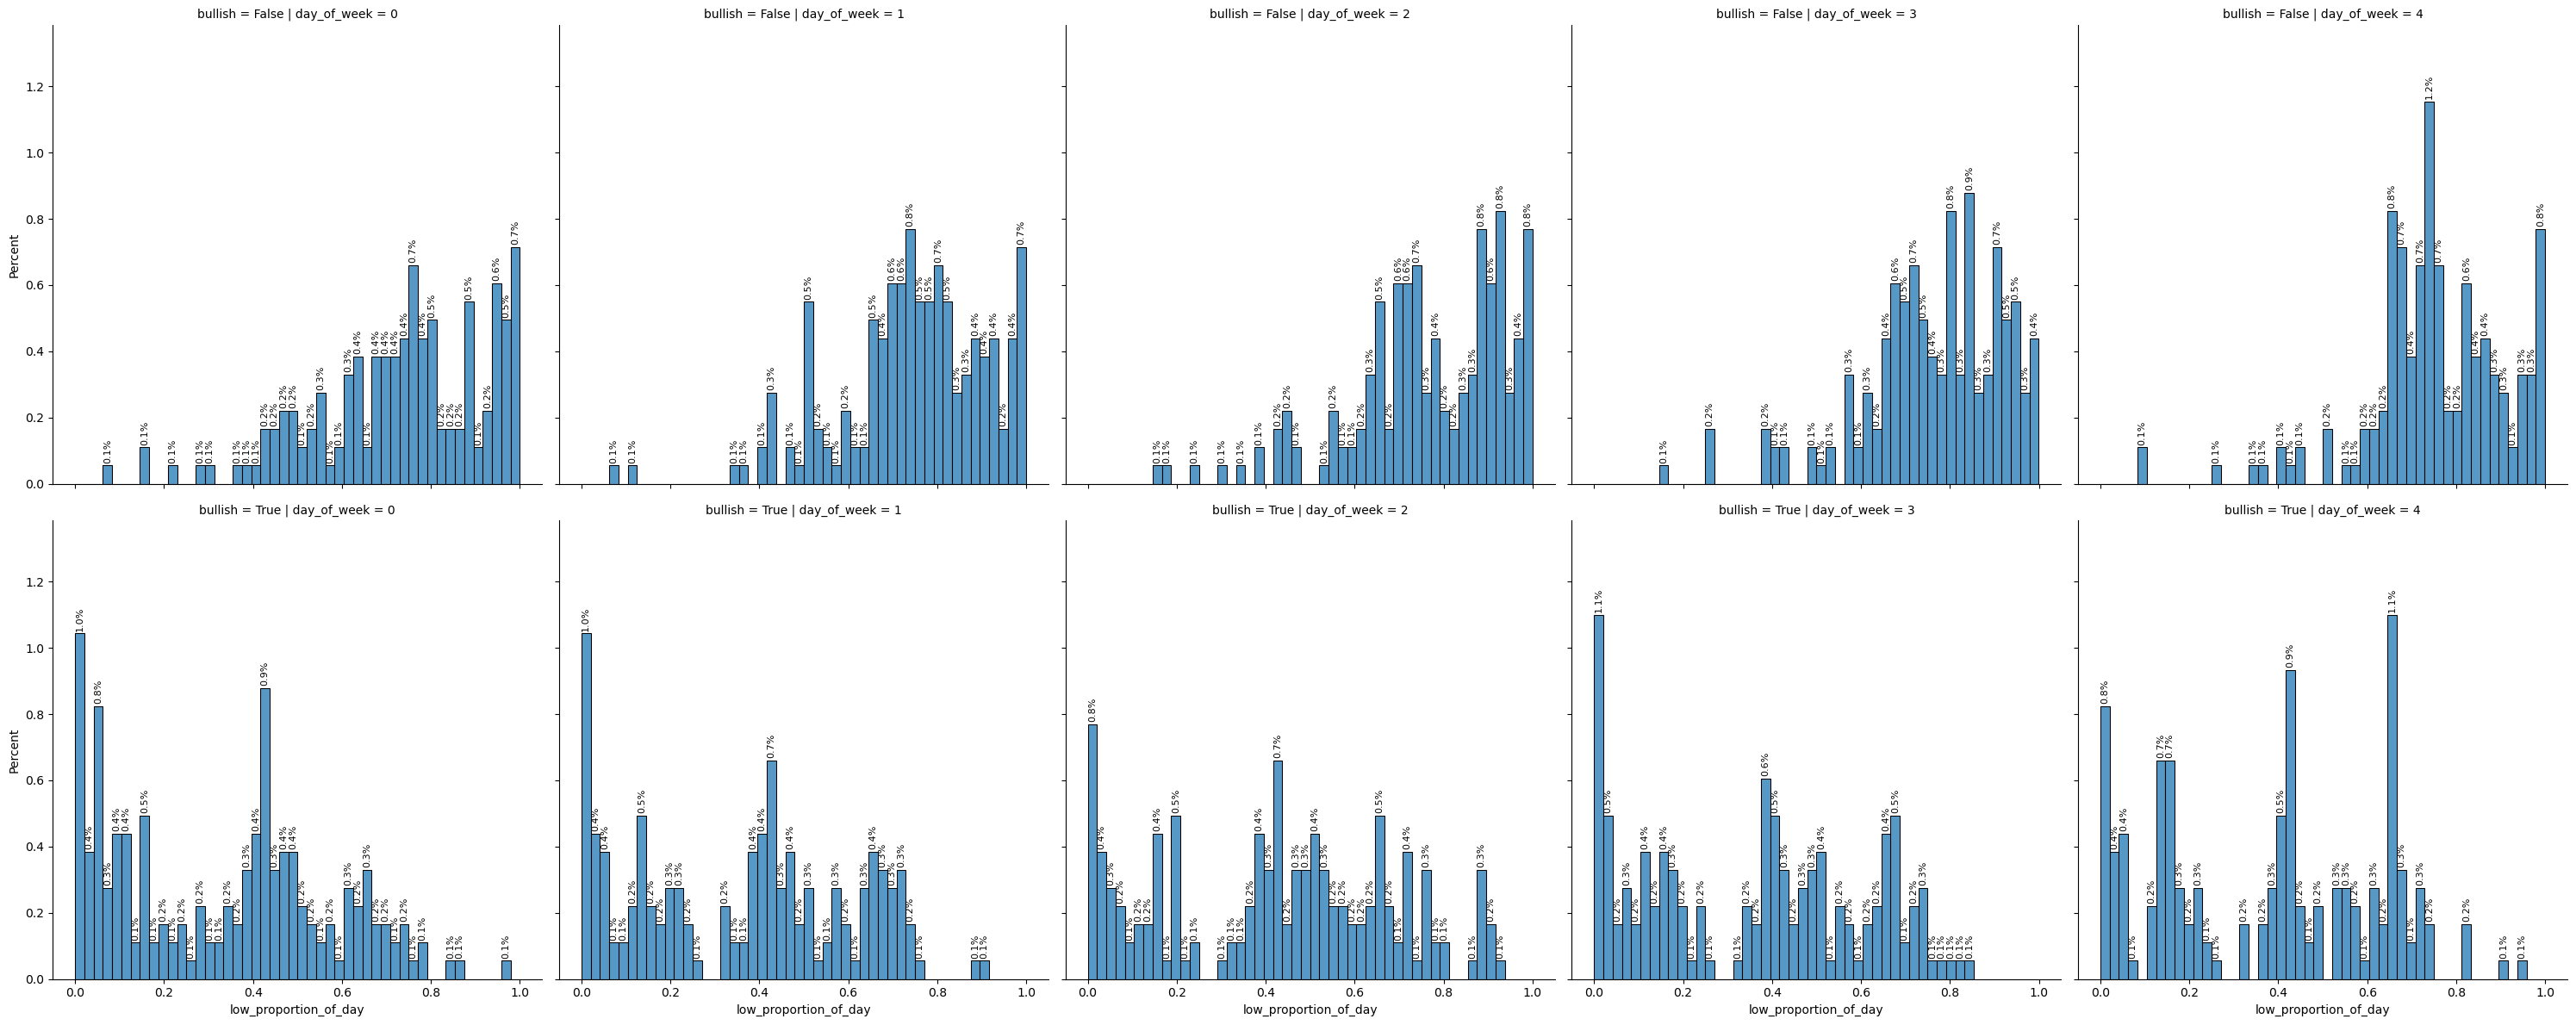

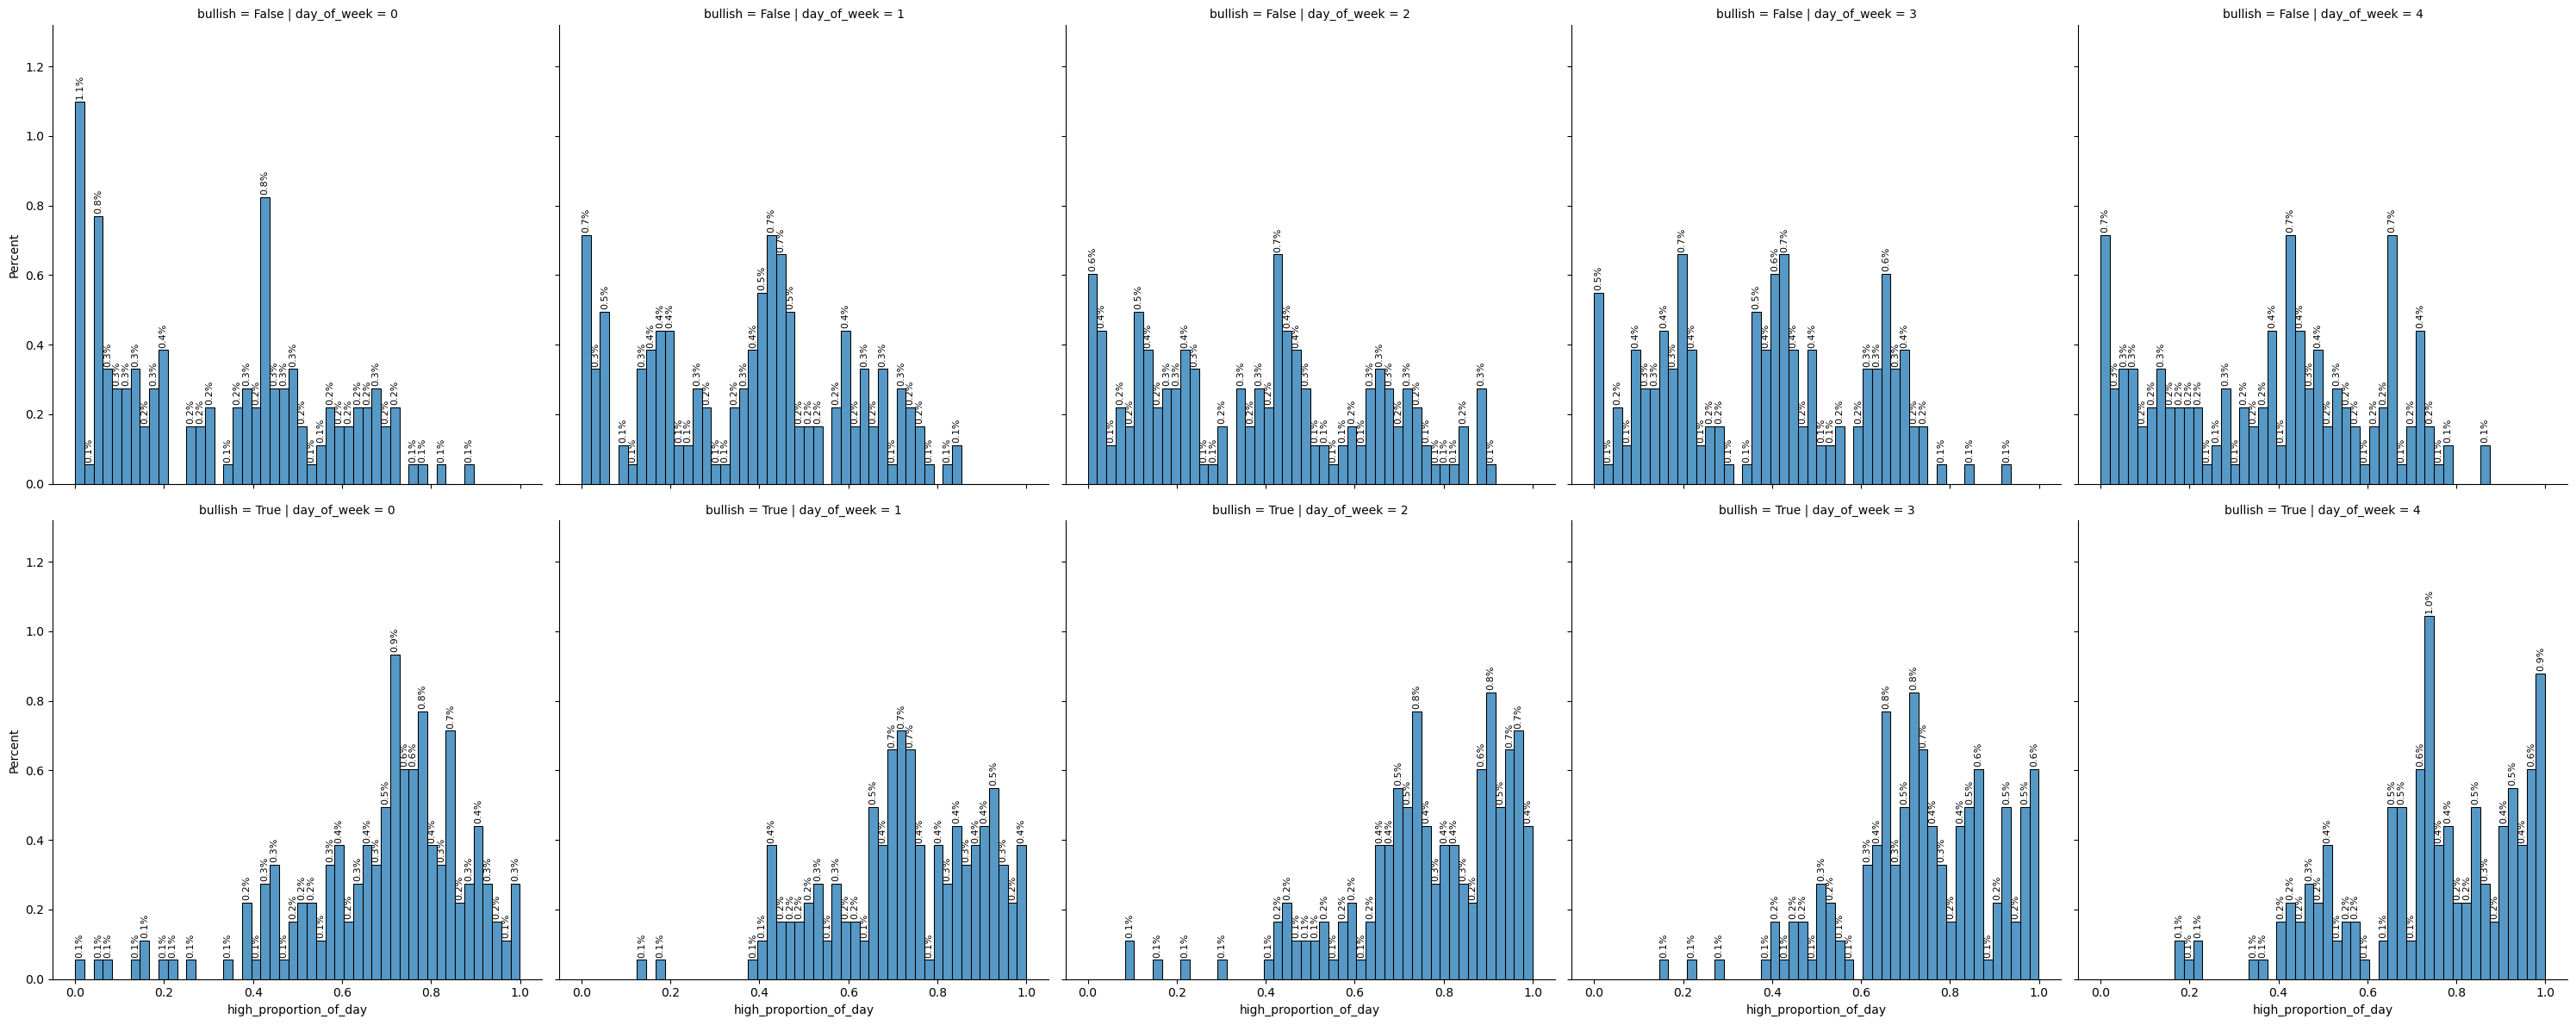

In [357]:
df_vis = df_daily
upbars = df_vis.bullish

# g = sns.displot(kind='hist', x=df_vis.low_proportion_of_day, col=upbars, height=6, stat='percent', bins=48)
# add_lables(g)

# g = sns.displot(kind='hist', x=df_vis.high_proportion_of_day, col=upbars, height=6, stat='percent', bins=48)
# add_lables(g)

# g = sns.displot(kind='hist', x=df_vis.low_proportion_of_day, height=6, stat='percent', bins=48)
# add_lables(g)

# g = sns.displot(kind='hist', x=df_vis.high_proportion_of_day, height=6, stat='percent', bins=48)
# add_lables(g)

upbars = df_vis.day_of_week

g = sns.displot(kind='hist', x=df_vis.low_proportion_of_day, row=df_vis.bullish, col=upbars, height=6, stat='percent', bins=48)
add_lables(g)

g = sns.displot(kind='hist', x=df_vis.high_proportion_of_day, row=df_vis.bullish, col=upbars, height=6, stat='percent', bins=48)
add_lables(g)

# g = sns.displot(kind='hist', x=df_vis.low_proportion_of_day, height=6, stat='percent', bins=48)
# add_lables(g)

# g = sns.displot(kind='hist', x=df_vis.high_proportion_of_day, height=6, stat='percent', bins=48)
# add_lables(g)

In [ ]:

binrange=[-150,150]

def add_lables(g):
    for ax in g.axes.ravel():
        # add annotations
        for c in ax.containers:

            # custom label calculates percent and add an empty string so 0 value bars dont have a number
            labels = ['{:0.1%}'.format(w/100) if (w := v.get_height()) > 0 else '' for v in c]

            ax.bar_label(c, labels=labels, label_type='edge', fontsize=8, rotation=90, padding=2)

        ax.margins(y=0.2)

        
def filterbars(start_time, end_time, atr_multiple_min=0, atr_multiple_max=9999):
    df_vis = df.between_time(start_time, end_time).dropna()
    df_vis_filtered = df_vis.query('BarRange > ATR_Market * ' + str(atr_multiple_min) + ' and BarRange < ATR_Market * ' + str(atr_multiple_max))
    print(df_vis_filtered[['ATR_Market', 'BarRange']].describe())
    return df_vis_filtered
        
def plotStats():

    df_vis = df
    upbars = df_vis.UpBar
    
    for i in range(1,11):
        g = sns.displot(kind='hist', x=(df_vis[colnames_close[i-1]]-df_vis.Close), col=upbars, height=6, aspect=1.2, binrange=binrange, stat='percent')
        g.set_axis_labels("Cumulative DAX Points", "% of Bars")
        add_lables(g)
        df_vis['Targettimeframe'] = df.Timestamp.shift(-i)
        g.fig.suptitle(str(i) +' - Distribution of Returns from '+ str(df_vis.iloc[0].Timestamp) + ' by ' + str(df_vis.iloc[0].Targettimeframe) + ' ATR min:' + str(atr_multiple_min) + ' ATR max:' + str(atr_multiple_max))
        g.map(plt.axvline, x=0, ls='--', c='red')
      
        g = sns.displot(kind="ecdf", x=(df_vis[colnames_close[i-1]]-df_vis.Close), col=upbars, height=6, aspect=1.2, stat='proportion')
        g.set_axis_labels("Cumulative DAX Points", "% of Bars")
        g.fig.suptitle('Cumulative Dist Func of Returns from '+ str(df_vis.iloc[0].Timestamp) + ' by ' + str(df_vis.iloc[0].Targettimeframe)  + ' ATR min:' + str(atr_multiple_min) + ' ATR max:' + str(atr_multiple_max))
        g.map(plt.axvline, x=0, ls='--', c='red')
        g.map(plt.axhline, y=0.5, ls='--', c='red')
        g.set(xlim=([-50, 50]))
        